## Audio Autoencoder (RNN Version)

## Imports

In [1]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import threading
import queue
import re

import torch
from torch import nn
from collections import OrderedDict

import torchaudio
from torchaudio.functional import highpass_biquad
import sounddevice as sd

from vocos import Vocos

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from PyQt5 import QtWidgets, QtCore
import pyqtgraph as pg
import sys

import IPython
from IPython.display import display
import ipywidgets as widgets

## Settings

## Device Settings

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device.upper()} device")

Using CPU device


## Audio Settings

In [3]:
audio_file = "data/audio/Take3_RO_37-4-1_HQ_audio_crop_48khz.wav"
audio_sample_rate = 48000
audio_channel_count = 1
audio_window_length = 2048
audio_output_device = 2 # windows: 7, macOS: 2
max_audio_queue_length = 32

audio_file_gui = widgets.Text(value=audio_file, description="Audio File:", style={'description_width': 'initial'}) 
audio_sample_rate_gui = widgets.IntText(value=audio_sample_rate, description="Audio Sample Rate:", style={'description_width': 'initial'})
audio_channel_count_gui = widgets.IntText(value=audio_channel_count, description="Audio Channel Count:", style={'description_width': 'initial'})
audio_window_length_gui = widgets.IntText(value=audio_window_length, description="Audio Window Length:", style={'description_width': 'initial'})
audio_output_device_gui = widgets.IntText(value=audio_output_device, description="Audio Output Device:", style={'description_width': 'initial'})
max_audio_queue_length_gui = widgets.IntText(value=max_audio_queue_length, description="Max Audio Queue Length:", style={'description_width': 'initial'})

display(audio_file_gui)
display(audio_sample_rate_gui)
display(audio_channel_count_gui)
display(audio_window_length_gui)
print(sd.query_devices())
display(audio_output_device_gui)
display(max_audio_queue_length_gui)

Text(value='data/audio/Take3_RO_37-4-1_HQ_audio_crop_48khz.wav', description='Audio File:', style=TextStyle(de…

IntText(value=48000, description='Audio Sample Rate:', style=DescriptionStyle(description_width='initial'))

IntText(value=1, description='Audio Channel Count:', style=DescriptionStyle(description_width='initial'))

IntText(value=2048, description='Audio Window Length:', style=DescriptionStyle(description_width='initial'))

  0 DELL U2413, Core Audio (0 in, 2 out)
> 1 MacBook Pro Microphone, Core Audio (1 in, 0 out)
< 2 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  3 ZoomAudioDevice, Core Audio (2 in, 2 out)


IntText(value=2, description='Audio Output Device:', style=DescriptionStyle(description_width='initial'))

IntText(value=32, description='Max Audio Queue Length:', style=DescriptionStyle(description_width='initial'))

In [4]:
audio_file = audio_file_gui.value
audio_sample_rate = audio_sample_rate_gui.value
audio_channel_count = audio_channel_count_gui.value
audio_window_length = audio_window_length_gui.value
audio_output_device = audio_output_device_gui.value
max_audio_queue_length = max_audio_queue_length_gui.value

gen_buffer_size = audio_window_length
window_size = gen_buffer_size
window_offset = window_size // 2
play_buffer_size = window_size * 16
playback_latency = 1.0

## Autoencoder Settings

In [5]:
latent_dim = 32
ae_rnn_layer_count = 2
ae_rnn_layer_size = 512
ae_dense_layer_sizes = [ 512 ]
ae_encoder_weights_file = "../Training/results/weights/encoder_weights_epoch_400"
ae_decoder_weights_file = "../Training/results/weights/decoder_weights_epoch_400"

latent_dim_gui = widgets.IntText(value=latent_dim, description="Latent Dimension:", style={'description_width': 'initial'})
ae_rnn_layer_count_gui = widgets.IntText(value=ae_rnn_layer_count, description="LSTM Layer Count:", style={'description_width': 'initial'})
ae_rnn_layer_size_gui = widgets.IntText(value=ae_rnn_layer_size, description="LSTM Layer Size:", style={'description_width': 'initial'})

ae_dense_layer_sizes_gui = widgets.Textarea(
    value=','.join(list(map(str, ae_dense_layer_sizes))),
    placeholder='Enter dense layer sizes separated by commas',
    description='Dense Layer Sizes:',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

ae_encoder_weights_file_gui = widgets.Text(value=ae_encoder_weights_file, description="Encoder Weights File:", style={'description_width': 'initial'}) 
ae_decoder_weights_file_gui = widgets.Text(value=ae_decoder_weights_file, description="Decoder Weights File:", style={'description_width': 'initial'}) 

display(latent_dim_gui)
display(ae_rnn_layer_count_gui)
display(ae_rnn_layer_size_gui)
display(ae_dense_layer_sizes_gui)
display(ae_encoder_weights_file_gui)
display(ae_decoder_weights_file_gui)

IntText(value=32, description='Latent Dimension:', style=DescriptionStyle(description_width='initial'))

IntText(value=2, description='LSTM Layer Count:', style=DescriptionStyle(description_width='initial'))

IntText(value=512, description='LSTM Layer Size:', style=DescriptionStyle(description_width='initial'))

Textarea(value='512', description='Dense Layer Sizes:', layout=Layout(width='50%'), placeholder='Enter dense l…

Text(value='../Training/results/weights/encoder_weights_epoch_400', description='Encoder Weights File:', style…

Text(value='../Training/results/weights/decoder_weights_epoch_400', description='Decoder Weights File:', style…

In [6]:
latent_dim = latent_dim_gui.value
ae_rnn_layer_count = ae_rnn_layer_count_gui.value
ae_rnn_layer_size = ae_rnn_layer_size_gui.value
ae_dense_layer_sizes  = [int(s) for s in re.split(r"\s*,\s*", ae_dense_layer_sizes_gui.value) if s.strip()]
ae_encoder_weights_file = ae_encoder_weights_file_gui.value
ae_decoder_weights_file = ae_decoder_weights_file_gui.value

## Load Audio

In [7]:
assert os.path.exists(audio_file), f"Audio file not found: {audio_file}"

audio_waveform, _ = torchaudio.load(audio_file)
audio_source_samples = audio_waveform[0].to(device)
audio_source_frame_index = 0
hann_window = torch.from_numpy(np.hanning(window_size)).float().to(device) # Move to device once

## Audio Excerpt Generation for 2D Mapping

In [8]:
audio_excerpt_frame_offset = 10000

audio_excerpt_frame_offset_gui = widgets.IntText(value=audio_excerpt_frame_offset, description="Audio Excerpt Frame Offset:", style={'description_width': 'initial'})

display(audio_excerpt_frame_offset_gui)

IntText(value=10000, description='Audio Excerpt Frame Offset:', style=DescriptionStyle(description_width='init…

In [9]:
audio_excerpt_frame_offset = audio_excerpt_frame_offset_gui.value

audio_excerpt_start_frame = 0
audio_excerpt_end_frame = audio_waveform.shape[1]
audio_excerpts = []
for fI in range(audio_excerpt_start_frame, audio_excerpt_end_frame - gen_buffer_size, audio_excerpt_frame_offset):
    audio_excerpt = audio_waveform[0, fI:fI + gen_buffer_size]
    audio_excerpts.append(audio_excerpt)
audio_excerpts = torch.stack(audio_excerpts, dim=0)

## Create Models

## Create Vocoder Model

In [10]:
vocos = Vocos.from_pretrained("kittn/vocos-mel-48khz-alpha1").to(device)
vocos.eval()

Vocos(
  (feature_extractor): MelSpectrogramFeatures(
    (mel_spec): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (backbone): VocosBackbone(
    (embed): Conv1d(128, 1024, kernel_size=(7,), stride=(1,), padding=(3,))
    (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (convnext): ModuleList(
      (0-7): 8 x ConvNeXtBlock(
        (dwconv): Conv1d(1024, 1024, kernel_size=(7,), stride=(1,), padding=(3,), groups=1024)
        (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (pwconv1): Linear(in_features=1024, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=2048, out_features=1024, bias=True)
      )
    )
    (final_layer_norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  )
  (head): ISTFTHead(
    (out): Linear(in_features=1024, out_features=2050, bias=True)
    (istft): ISTFT()
  )
)

## Determine Number of Mel Filters and Mel Spectra

In [11]:
with torch.no_grad():
    dummy_features = vocos.feature_extractor(torch.rand(size=(1, gen_buffer_size), device=device))
    mel_count = dummy_features.shape[-1]
    mel_filters = dummy_features.shape[1]

## Create Encoder

In [12]:
class Encoder(nn.Module):
    def __init__(self, sequence_length, mel_filter_count, latent_dim, rnn_layer_count, rnn_layer_size, dense_layer_sizes):
        super(Encoder, self).__init__()
        
        self.sequence_length = sequence_length
        self.mel_filter_count = mel_filter_count
        self.latent_dim = latent_dim
        self.rnn_layer_count = rnn_layer_count
        self.rnn_layer_size = rnn_layer_size 
        self.dense_layer_sizes = dense_layer_sizes
    
        rnn_layers = []
        rnn_layers.append(("encoder_rnn_0", nn.LSTM(self.mel_filter_count, self.rnn_layer_size, self.rnn_layer_count, batch_first=True)))
        
        self.rnn_layers = nn.Sequential(OrderedDict(rnn_layers))
 
        dense_layers = []
        
        dense_layers.append(("encoder_dense_0", nn.Linear(self.rnn_layer_size, self.dense_layer_sizes[0])))
        dense_layers.append(("encoder_dense_relu_0", nn.ReLU()))
        
        dense_layer_count = len(self.dense_layer_sizes)
        for layer_index in range(1, dense_layer_count):
            dense_layers.append(("encoder_dense_{}".format(layer_index), nn.Linear(self.dense_layer_sizes[layer_index-1], self.dense_layer_sizes[layer_index])))
            dense_layers.append(("encoder_dense_relu_{}".format(layer_index), nn.ReLU()))
        
        self.dense_layers = nn.Sequential(OrderedDict(dense_layers))
        self.fc_mu = nn.Linear(self.dense_layer_sizes[-1], self.latent_dim)
        self.fc_std = nn.Linear(self.dense_layer_sizes[-1], self.latent_dim)
        
    def forward(self, x):

        x, (_, _) = self.rnn_layers(x)
        x = x[:, -1, :] # only last time step 
        x = self.dense_layers(x)
        mu = self.fc_mu(x)
        std = self.fc_std(x)
  
        return mu, std

    @staticmethod
    def reparameterize(mu, std):
        z = mu + std*torch.randn_like(std)
        return z

# ==== Instantiate and load weights ====
encoder = Encoder(mel_count, mel_filters, latent_dim, ae_rnn_layer_count, ae_rnn_layer_size, ae_dense_layer_sizes).to(device)
encoder.load_state_dict(torch.load(ae_encoder_weights_file, map_location=device))
encoder.eval()

Encoder(
  (rnn_layers): Sequential(
    (encoder_rnn_0): LSTM(128, 512, num_layers=2, batch_first=True)
  )
  (dense_layers): Sequential(
    (encoder_dense_0): Linear(in_features=512, out_features=512, bias=True)
    (encoder_dense_relu_0): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_std): Linear(in_features=512, out_features=32, bias=True)
)

## Create Decoder

In [13]:
class Decoder(nn.Module):
    def __init__(self, sequence_length, mel_filter_count, latent_dim, rnn_layer_count, rnn_layer_size, dense_layer_sizes):
        super(Decoder, self).__init__()
        
        self.sequence_length = sequence_length
        self.mel_filter_count = mel_filter_count
        self.latent_dim = latent_dim
        self.rnn_layer_size = rnn_layer_size
        self.rnn_layer_count = rnn_layer_count
        self.dense_layer_sizes = dense_layer_sizes

        # create dense layers
        dense_layers = []
        
        dense_layers.append(("decoder_dense_0", nn.Linear(latent_dim, self.dense_layer_sizes[0])))
        dense_layers.append(("decoder_relu_0", nn.ReLU()))

        dense_layer_count = len(self.dense_layer_sizes)
        for layer_index in range(1, dense_layer_count):
            dense_layers.append(("decoder_dense_{}".format(layer_index), nn.Linear(self.dense_layer_sizes[layer_index-1], self.dense_layer_sizes[layer_index])))
            dense_layers.append(("decoder_dense_relu_{}".format(layer_index), nn.ReLU()))
 
        self.dense_layers = nn.Sequential(OrderedDict(dense_layers))
        
        # create rnn layers
        rnn_layers = []

        rnn_layers.append(("decoder_rnn_0", nn.LSTM(self.dense_layer_sizes[-1], self.rnn_layer_size, self.rnn_layer_count, batch_first=True)))
        
        self.rnn_layers = nn.Sequential(OrderedDict(rnn_layers))
        
        # final output dense layer
        final_layers = []
        
        final_layers.append(("decoder_dense_{}".format(dense_layer_count), nn.Linear(self.rnn_layer_size, self.mel_filter_count)))
        
        self.final_layers = nn.Sequential(OrderedDict(final_layers))
        
    def forward(self, x):
        # dense layers
        x = self.dense_layers(x)
        
        # repeat vector
        x = torch.unsqueeze(x, dim=1)
        x = x.repeat(1, self.sequence_length, 1)
        
        # rnn layers
        x, (_, _) = self.rnn_layers(x)

        # final time distributed dense layer
        x_reshaped = x.contiguous().view(-1, self.rnn_layer_size)  # (batch_size * sequence, input_size)
        yhat = self.final_layers(x_reshaped)
        yhat = yhat.contiguous().view(-1, self.sequence_length, self.mel_filter_count)

        return yhat

# ==== Instantiate and load weights ====
decoder = Decoder(mel_count, mel_filters, latent_dim, ae_rnn_layer_count, ae_rnn_layer_size, list(reversed(ae_dense_layer_sizes))).to(device)
decoder.load_state_dict(torch.load(ae_decoder_weights_file, map_location=device))
decoder.eval()

Decoder(
  (dense_layers): Sequential(
    (decoder_dense_0): Linear(in_features=32, out_features=512, bias=True)
    (decoder_relu_0): ReLU()
  )
  (rnn_layers): Sequential(
    (decoder_rnn_0): LSTM(512, 512, num_layers=2, batch_first=True)
  )
  (final_layers): Sequential(
    (decoder_dense_1): Linear(in_features=512, out_features=128, bias=True)
  )
)

## Generate latent encodings and 2D projections

In [14]:
batch_size = 32

batch_size_gui = widgets.IntText(value=batch_size, description="Batch Size:", style={'description_width': 'initial'})

display(batch_size_gui)

IntText(value=32, description='Batch Size:', style=DescriptionStyle(description_width='initial'))

In [15]:
batch_size = batch_size_gui.value

with torch.no_grad():
    audio_encodings = []
    for eI in range(0, audio_excerpts.shape[0] - batch_size, batch_size):
        batch = audio_excerpts[eI:eI+batch_size].to(device)
        mels = vocos.feature_extractor(batch)
        audio_encoder_in = mels.permute((0, 2, 1))
        mu, std = encoder(audio_encoder_in)
        std = torch.nn.functional.softplus(std) + 1e-6
        encoded_batch = Encoder.reparameterize(mu, std).detach().cpu()
        audio_encodings.append(encoded_batch)
    audio_encodings = torch.cat(audio_encodings, dim=0).numpy()
tsne = TSNE(n_components=2, max_iter=5000, verbose=1)
Z_tsne = tsne.fit_transform(audio_encodings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1184 samples in 0.000s...
[t-SNE] Computed neighbors for 1184 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1184
[t-SNE] Computed conditional probabilities for sample 1184 / 1184
[t-SNE] Mean sigma: 1.786013
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.103439
[t-SNE] KL divergence after 5000 iterations: 1.600708


## Display 2D Projection

<Figure size 640x480 with 0 Axes>

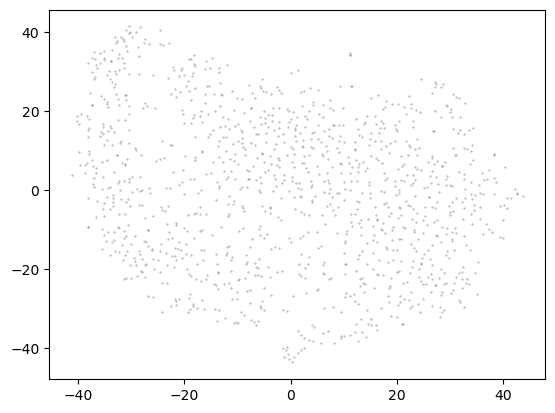

In [16]:
Z_tsne_x = Z_tsne[:,0]
Z_tsne_y = Z_tsne[:,1]

plt.figure()
fig, ax = plt.subplots()
ax.scatter(Z_tsne_x, Z_tsne_y, s=0.1, c="grey", alpha=1.0)

## K-Nearest-Neighbors Search based on Mouse Clicks

In [17]:
n_neighbors = 4

n_neighbors_gui = widgets.IntText(value=n_neighbors, description="Neighbour Count:", style={'description_width': 'initial'})

display(n_neighbors_gui)

IntText(value=4, description='Neighbour Count:', style=DescriptionStyle(description_width='initial'))

In [18]:
n_neighbors = n_neighbors_gui.value

knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')
knn.fit(Z_tsne)

def calc_distance_based_averaged_encoding(point2D):
    """Returns distance-weighted averaged encoding for a given 2D point."""
    _, indices = knn.kneighbors(point2D)
    nearest_positions = Z_tsne[indices[0]]
    nearest_encodings = audio_encodings[indices[0]]
    nearest_2D_distances = np.linalg.norm(nearest_positions - point2D, axis=1)
    max_2D_distance = np.max(nearest_2D_distances)
    norm_nearest_2D_distances = nearest_2D_distances / max_2D_distance
    weights = (1.0 - norm_nearest_2D_distances)
    return np.average(nearest_encodings, weights=weights, axis=0)

## Real-Time Audio Callback Functions

In [19]:
inter_audio_encodings = []
inter_audio_encoding_index = 0

@torch.no_grad()
def encode_audio(waveform):
    waveform = waveform.unsqueeze(0).to(device)
    mels = vocos.feature_extractor(waveform)
    audio_encoder_in = mels.permute((0, 2, 1))
    mu, std = encoder(audio_encoder_in)
    std = torch.nn.functional.softplus(std) + 1e-6
    return Encoder.reparameterize(mu, std)

@torch.no_grad()
def decode_audio(latent):
    mel_pred = decoder(latent).squeeze(1)
    mel_pred = mel_pred.permute((0, 2, 1))
    mel_pred = mel_pred.squeeze(1)
    waveform = vocos.decode(mel_pred).reshape(1, -1)
    return waveform

@torch.no_grad()
def synthesize_audio():
    """Decode the next latent encoding from the current interactive list."""
    global inter_audio_encoding_index
    if len(inter_audio_encodings) == 0:
        return torch.zeros(gen_buffer_size)
    inter_audio_encoding_index += 1
    if inter_audio_encoding_index >= len(inter_audio_encodings):
        inter_audio_encoding_index = 0
    latent = inter_audio_encodings[inter_audio_encoding_index]
    gen_waveform = decode_audio(latent).reshape(-1)
    return gen_waveform

## Audio Threading

In [20]:
audio_queue = queue.Queue(maxsize=max_audio_queue_length)
export_audio_buffer = []
last_chunk = np.zeros(window_size, dtype=np.float32)

def producer_thread():
    """Continuously generates audio and fills the output buffer queue."""
    while True:
        if not audio_queue.full():
            gen_waveform = synthesize_audio()
            audio_queue.put(gen_waveform.cpu().numpy())
        else:
            sd.sleep(10)

def audio_callback(out_data, frames, time_info, status):
    """sounddevice stream callback function."""
    global last_chunk
    output = np.zeros((frames, audio_channel_count), dtype=np.float32)
    cursor = 0
    overlap_len = window_size // 2
    output[cursor:cursor+overlap_len, 0] += last_chunk[overlap_len:]
    samples_needed = frames
    while samples_needed > 0:
        try:
            chunk = audio_queue.get_nowait()
            chunk = (chunk * hann_window.cpu().numpy())
        except queue.Empty:
            chunk = np.zeros(window_size, dtype=np.float32)
        chunk_copy_size = output[cursor:cursor+window_size, 0].shape[0]
        output[cursor:cursor+chunk_copy_size, 0] += chunk[:chunk_copy_size]
        cursor += window_size // 2
        samples_needed = frames - cursor
        last_chunk[:] = chunk[:]
    out_data[:] = output

def run_audio_stream():
    """Main thread for launching audio producer and output stream."""
    threading.Thread(target=producer_thread, daemon=True).start()
    sd.sleep(2000)
    with sd.OutputStream(
        samplerate=audio_sample_rate,
        device=audio_output_device,
        channels=audio_channel_count,
        callback=audio_callback,
        blocksize=play_buffer_size,
        latency=playback_latency
    ):
        print("Streaming audio with FIFO queue... press Ctrl+C to stop.")
        try:
            while True:
                sd.sleep(1000)
        except KeyboardInterrupt:
            print("\nStopped.")

## Scatter Plot Application

In [21]:
class ScatterPlotApp(QtWidgets.QMainWindow):
    """
    Interactive scatter plot GUI for latent encodings.
    - Left button press/drag: Add points and encodings.
    - Right button press/drag: Remove points and corresponding encodings near cursor.
    - Middle button: pan plot.
    - 'C' key: clear all points/encodings.
    """
    def __init__(self, points2D, inter_audio_encodings):
        super().__init__()
        self.setWindowTitle("2D Scatter Plot with Click and Drag")
        # Container and layout for pyqtgraph widget
        container_widget = QtWidgets.QWidget()
        layout = QtWidgets.QVBoxLayout(container_widget)
        self.graph_widget = pg.PlotWidget()
        layout.addWidget(self.graph_widget)
        self.setCentralWidget(container_widget)

        # Main scatter item (fixed background points)
        self.scatter = pg.ScatterPlotItem(
            x=points2D[:, 0],
            y=points2D[:, 1],
            pen=pg.mkPen(None),
            brush=pg.mkBrush(100, 100, 255, 120),
            size=10
        )
        self.graph_widget.addItem(self.scatter)

        # Interactive points and encodings (red points are user-selected)
        self.click_points = []
        self.click_scatter = pg.ScatterPlotItem(size=12, brush=pg.mkBrush(255, 0, 0, 200))
        self.graph_widget.addItem(self.click_scatter)
        
        # Audio playback point
        self.play_point = []
        self.play_scatter = pg.ScatterPlotItem(size=12, brush=pg.mkBrush(0, 255, 0, 200))
        self.graph_widget.addItem(self.play_scatter)

        # Interaction state
        self.left_button_pressed = False
        self.middle_button_pressed = False
        self.right_button_pressed = False
        self.last_mouse_pos = None

        # Timer for continuous add (while dragging left button)
        self.timer = QtCore.QTimer()
        self.timer.setInterval(100)  # ms
        self.timer.timeout.connect(self.continuous_add_point)
        
        # Timer for updating play point
        self.playpoint_timer = QtCore.QTimer()
        self.playpoint_timer.setInterval(25)  # ms
        self.playpoint_timer.timeout.connect(self.update_play_point)
        self.playpoint_timer.start()

        # Register event filter for mouse events
        self.graph_widget.scene().installEventFilter(self)
        self.click_encodings = inter_audio_encodings

    def addInteractiveEncoding(self, mouse_point):
        """Add an encoding for the clicked position."""
        encoding = calc_distance_based_averaged_encoding(np.array([[mouse_point.x(), mouse_point.y()]]))
        encoding = torch.from_numpy(encoding).unsqueeze(0).to(torch.float32).to(device)
        self.click_encodings.append(encoding)

    def removeInteractiveEncodingNear(self, mouse_point, radius=0.5):
        """Remove points and encodings within a radius of the mouse cursor."""
        to_remove_indices = []
        mp_x, mp_y = mouse_point.x(), mouse_point.y()
        for i, p in enumerate(self.click_points):
            dx = p['pos'][0] - mp_x
            dy = p['pos'][1] - mp_y
            dist = (dx*dx + dy*dy)**0.5
            if dist < radius:
                to_remove_indices.append(i)
        # Remove from lists in reverse order for safety
        for idx in reversed(to_remove_indices):
            self.click_points.pop(idx)
            self.click_encodings.pop(idx)
        # Update plot
        self.click_scatter.setData(
            [p['pos'][0] for p in self.click_points],
            [p['pos'][1] for p in self.click_points]
        )

    def clearInteractiveEncodings(self):
        """Clear all interactive points and encodings."""
        self.click_points.clear()
        self.click_scatter.setData([], [])
        self.click_encodings.clear()

    def eventFilter(self, source, event):
        """Handle mouse events for the plot."""
        if source == self.graph_widget.scene():
            if event.type() == QtCore.QEvent.GraphicsSceneMousePress:
                if event.button() == QtCore.Qt.LeftButton:
                    self.left_button_pressed = True
                    self.last_mouse_pos = event.scenePos()
                    self.add_point_at(event.scenePos())
                    self.timer.start()
                    return True
                elif event.button() == QtCore.Qt.MiddleButton:
                    self.middle_button_pressed = True
                    self.last_mouse_pos = event.scenePos()
                    return True
                elif event.button() == QtCore.Qt.RightButton:
                    self.right_button_pressed = True
                    self.last_mouse_pos = event.scenePos()
                    return True
            elif event.type() == QtCore.QEvent.GraphicsSceneMouseRelease:
                if event.button() == QtCore.Qt.LeftButton:
                    self.left_button_pressed = False
                    self.timer.stop()
                    return True
                elif event.button() == QtCore.Qt.MiddleButton:
                    self.middle_button_pressed = False
                    return True
                elif event.button() == QtCore.Qt.RightButton:
                    self.right_button_pressed = False
                    return True
            elif event.type() == QtCore.QEvent.GraphicsSceneMouseMove:
                if self.left_button_pressed:
                    self.last_mouse_pos = event.scenePos()
                    return True
                elif self.middle_button_pressed:
                    if self.last_mouse_pos is not None:
                        diff = event.scenePos() - self.last_mouse_pos
                        vb = self.graph_widget.plotItem.vb
                        vb.translateBy(x=-diff.x(), y=diff.y())
                        self.last_mouse_pos = event.scenePos()
                    return True
                elif self.right_button_pressed:
                    # Remove points near mouse position on drag
                    vb = self.graph_widget.plotItem.vb
                    mouse_point = vb.mapSceneToView(event.scenePos())
                    self.removeInteractiveEncodingNear(mouse_point)
                    self.last_mouse_pos = event.scenePos()
                    return True
        return super().eventFilter(source, event)

    def keyPressEvent(self, event):
        """Clear points/encodings on 'C' key."""
        if event.key() == QtCore.Qt.Key_C:
            self.clearInteractiveEncodings()
        super().keyPressEvent(event)

    def add_point_at(self, scene_pos):
        """Add a scatter point and encoding at mouse position."""
        if self.graph_widget.sceneBoundingRect().contains(scene_pos):
            vb = self.graph_widget.plotItem.vb
            mouse_point = vb.mapSceneToView(scene_pos)
            self.addInteractiveEncoding(mouse_point)
            x, y = mouse_point.x(), mouse_point.y()
            self.click_points.append({'pos': (x, y)})
            self.click_scatter.setData(
                [p['pos'][0] for p in self.click_points],
                [p['pos'][1] for p in self.click_points]
            )

    def continuous_add_point(self):
        """Timer-driven continuous interactive addition while dragging."""
        if self.left_button_pressed and self.last_mouse_pos is not None:
            self.add_point_at(self.last_mouse_pos)
            
    def update_play_point(self):
        
        global inter_audio_encoding_index
        
        if inter_audio_encoding_index >= len(self.click_points):
            return
        
        play_p = self.click_points[inter_audio_encoding_index]

        self.play_scatter.setData( [ play_p['pos'][0] ], [ play_p['pos'][1] ] )

## Run Application

In [22]:
# Run audio stream in separate thread for GUI/audio concurrency
audio_thread = threading.Thread(target=run_audio_stream, daemon=True)
audio_thread.start()
app = QtWidgets.QApplication(sys.argv)
main = ScatterPlotApp(Z_tsne, inter_audio_encodings)
main.show()
sys.exit(app.exec_())

Streaming audio with FIFO queue... press Ctrl+C to stop.


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


SystemExit: 0

/Users/dbisig/opt/anaconda3/envs/premiere_test4/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
